In [52]:
# Install libraries
#install.packages("pROC")
#install.packages("vctrs")
#install.packages("caret")
#install.packages("nnet")
#install.packages("ggplot2")
#install.packages("cowplot")
#install.packages("dplyr")
#install.packages("glmnet")

# Load libraries
library(pROC)
library(vctrs)
library(caret)
library(nnet)
library(ggplot2)
library(cowplot)
library(dplyr)
library(glmnet)

In [53]:
rm(list=ls()) #clears the workspace
data <- read.csv("SEIFA_RTT_LGA.csv")

# Remove rows with NAs in important percentile columns
cleaned_data <- data[complete.cases(data), ]

print(colnames(cleaned_data))

 [1] "lga_code"                  "IRSD.Decile"              
 [3] "IRSAD.Decile"              "IER.Decile"               
 [5] "IEO.Decile"                "Median.Income"            
 [7] "Lowest.Quartile.Income.."  "Highest.Quartile.Income.."
 [9] "Gini.Coefficient"          "Area..Km.2."              
[11] "Population"                "Population.Density"       
[13] "Population.Change"         "Population.Change.."      
[15] "Indigenous.Population"     "Indigenous.Population.."  
[17] "X5th.Percentile"           "X50th.Percentile"         
[19] "X95th.Percentile"          "X95th.5th.Ratio"          
[21] "major_city_distance"       "closest_capital_distance" 
[23] "own_capital_distance"      "Major.City"               
[25] "Inner.Regional"            "Outer.Regional"           
[27] "Remote"                    "Very.Remote"              
[29] "Division"                  "Previous.Party"           
[31] "Previous.Seat.Status"      "Successful.Party"         
[33] "Current.Seat.Statu

In [54]:
print('Number of rows in cleaned data:')
print(nrow(cleaned_data))

[1] "Number of rows in cleaned data:"
[1] 401


# BIG regression
### fit with all variables

   Remoteness_Area_1 Remoteness_Area_2   Mean_1   Mean_2      p_value
1         Major City    Inner Regional 2.627939 2.612283    0.7969307
2         Major City    Outer Regional 2.627939 2.251954 3.676235e-07
3         Major City            Remote 2.627939 2.241260  0.005570406
4         Major City       Very Remote 2.627939 2.164301 9.580539e-05
5     Inner Regional    Outer Regional 2.612283 2.251954 2.348145e-06
6     Inner Regional            Remote 2.612283 2.241260  0.008052161
7     Inner Regional       Very Remote 2.612283 2.164301 0.0001787961
8     Outer Regional            Remote 2.251954 2.241260    0.9382344
9     Outer Regional       Very Remote 2.251954 2.164301    0.4580679
10            Remote       Very Remote 2.241260 2.164301      0.63291
    Difference
1  -0.01565614
2  -0.37598508
3  -0.38667963
4  -0.46363879
5  -0.36032894
6  -0.37102350
7  -0.44798265
8  -0.01069456
9  -0.08765371
10 -0.07695916


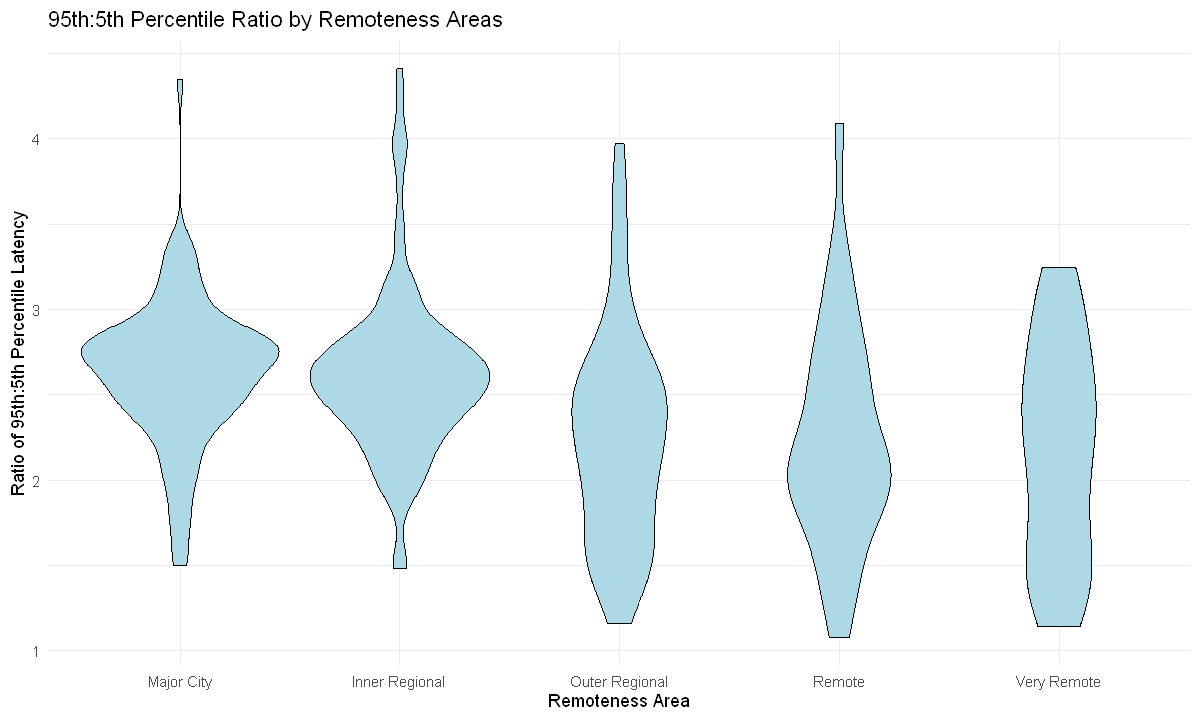

In [55]:
cleaned_data$Remoteness <- ifelse(cleaned_data$Major.City == 1, "Major City", ifelse(cleaned_data$Inner.Regional == 1, "Inner Regional", ifelse(cleaned_data$Outer.Regional == 1, "Outer Regional", ifelse(cleaned_data$Remote == 1, "Remote", "Very Remote"))))
cleaned_data$Remoteness <- factor(cleaned_data$Remoteness, levels = c("Major City", "Inner Regional", "Outer Regional", "Remote", "Very Remote"))

# Create the violin plot and assign it to variable 'p'
ggplot(cleaned_data, aes(x = Remoteness, y = X95th.5th.Ratio)) +
  geom_violin(fill = "lightblue", color = "black") +
  labs(x = "Remoteness Area", y = "Ratio of 95th:5th Percentile Latency",
       title = "95th:5th Percentile Ratio by Remoteness Areas") +
  theme_minimal()

# Create a data frame to store results of t-tests
results_table <- data.frame(Remoteness_Area_1 = character(), 
                             Remoteness_Area_2 = character(), 
                             Mean_1 = numeric(), 
                             Mean_2 = numeric(),
                             p_value = numeric(), 
                             Difference = numeric(), 
                             stringsAsFactors = FALSE)

# Perform t-tests between each pair of remoteness levels
remoteness_levels <- levels(cleaned_data$Remoteness)

for (i in 1:(length(remoteness_levels) - 1)) {
  for (j in (i + 1):length(remoteness_levels)) {
    test <- t.test(X95th.5th.Ratio ~ Remoteness, 
                   data = cleaned_data[cleaned_data$Remoteness %in% c(remoteness_levels[i], remoteness_levels[j]), ])
    
    # Calculate means
    mean_1 <- mean(cleaned_data$X95th.5th.Ratio[cleaned_data$Remoteness == remoteness_levels[i]], na.rm = TRUE)
    mean_2 <- mean(cleaned_data$X95th.5th.Ratio[cleaned_data$Remoteness == remoteness_levels[j]], na.rm = TRUE)
    
    # Add results to the data frame
    results_table <- rbind(results_table, 
                            data.frame(Remoteness_Area_1 = remoteness_levels[i], 
                                       Remoteness_Area_2 = remoteness_levels[j], 
                                       Mean_1 = mean_1, Mean_2 = mean_2,
                                       p_value = format(test$p.value, nsmall = 5),
                                       Difference = mean_2 - mean_1))
  }
}

# Print the results table
print(results_table)

## Begin Fitting

In [56]:
urban_data <- cleaned_data[(cleaned_data$Major.City == 1) | (cleaned_data$Inner.Regional == 1), ]
rural_data <- cleaned_data[(cleaned_data$Major.City == 0) & (cleaned_data$Inner.Regional == 0), ]

In [57]:
cor_matrix <- cor(cleaned_data[, c("IRSD.Decile", "IRSAD.Decile", "IER.Decile",
                            "IEO.Decile", "Median.Income",
                            "Lowest.Quartile.Income..",
                            "Highest.Quartile.Income..", "Gini.Coefficient",
                            "Area..Km.2.", "major_city_distance",
                            "closest_capital_distance", "own_capital_distance",
                            "Population", "Population.Density", 
                            "Population.Change", "Population.Change..",
                            "Indigenous.Population", "Indigenous.Population..",
                            "Swing", "Seat.Change", "is.Safe", "is.Marginal",
                            "Remained.Marginal")], use = "complete.obs")
#cor_matrix

#write.csv(cor_matrix, file = "correlation_matrix.csv", row.names = FALSE)

urban_cor_matrix <- cor(urban_data[, c("IRSD.Decile", "IRSAD.Decile", "IER.Decile",
                            "IEO.Decile", "Median.Income",
                            "Lowest.Quartile.Income..",
                            "Highest.Quartile.Income..", "Gini.Coefficient",
                            "Area..Km.2.", "major_city_distance",
                            "closest_capital_distance", "own_capital_distance",
                            "Population", "Population.Density", 
                            "Population.Change", "Population.Change..",
                            "Indigenous.Population", "Indigenous.Population..",
                            "Swing", "Seat.Change", "is.Safe", "is.Marginal",
                            "Remained.Marginal")], use = "complete.obs")

#write.csv(urban_cor_matrix, file = "urban_correlation_matrix.csv", row.names = FALSE)

# rural correlation matrix
rural_cor_matrix <- cor(rural_data[, c("IRSD.Decile", "IRSAD.Decile", "IER.Decile",
                            "IEO.Decile", "Median.Income",
                            "Lowest.Quartile.Income..",
                            "Highest.Quartile.Income..", "Gini.Coefficient",
                            "Area..Km.2.", "major_city_distance",
                            "closest_capital_distance", "own_capital_distance",
                            "Population", "Population.Density", 
                            "Population.Change", "Population.Change..",
                            "Indigenous.Population", "Indigenous.Population..",
                            "Swing", "Seat.Change", "is.Safe", "is.Marginal",
                            "Remained.Marginal")], use = "complete.obs")

#write.csv(rural_cor_matrix, file = "rural_correlation_matrix.csv", row.names = FALSE)


Warning message in cor(rural_data[, c("IRSD.Decile", "IRSAD.Decile", "IER.Decile", :
"the standard deviation is zero"


In [92]:
fit <- lm(cleaned_data$X95th.Percentile ~ IRSAD.Decile +
            Gini.Coefficient + Area..Km.2. +  
            closest_capital_distance + Population + Population.Density + 
            + Population.Change.. + Indigenous.Population.. +
            Swing + is.Safe + is.Marginal +
            Remained.Marginal, data = cleaned_data)

## AIC

In [93]:
# Fit the model with stepwise AIC selection
fit_aic <- step(fit)
summary(fit_aic)

Start:  AIC=3664.48
cleaned_data$X95th.Percentile ~ IRSAD.Decile + Gini.Coefficient + 
    Area..Km.2. + closest_capital_distance + Population + Population.Density + 
    +Population.Change.. + Indigenous.Population.. + Swing + 
    is.Safe + is.Marginal + Remained.Marginal

                           Df Sum of Sq     RSS    AIC
- IRSAD.Decile              1       192 3497405 3662.5
- Swing                     1       536 3497748 3662.5
- Area..Km.2.               1       870 3498083 3662.6
- Population                1      1598 3498811 3662.7
- is.Marginal               1      3786 3500999 3662.9
- closest_capital_distance  1      3872 3501084 3662.9
- Remained.Marginal         1      6365 3503578 3663.2
- is.Safe                   1     10840 3508052 3663.7
- Population.Density        1     14380 3511592 3664.1
<none>                                  3497212 3664.5
- Population.Change..       1     25365 3522578 3665.4
- Gini.Coefficient          1     29185 3526398 3665.8
- Indigen


Call:
lm(formula = cleaned_data$X95th.Percentile ~ Gini.Coefficient + 
    Population.Change.. + Indigenous.Population.., data = cleaned_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-232.60  -40.00   -9.43   17.30  560.38 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)             399.2302    37.5584  10.630  < 2e-16 ***
Gini.Coefficient        115.2597    72.9162   1.581  0.11474    
Population.Change..       8.1400     4.2465   1.917  0.05597 .  
Indigenous.Population..  -0.9278     0.3405  -2.725  0.00672 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 94.47 on 397 degrees of freedom
Multiple R-squared:  0.03921,	Adjusted R-squared:  0.03195 
F-statistic: 5.401 on 3 and 397 DF,  p-value: 0.001189


## BIC

In [94]:
fit_bic <- step(fit, direction = "both", k = log(nrow(cleaned_data)))
summary(fit_bic)

Start:  AIC=3716.4
cleaned_data$X95th.Percentile ~ IRSAD.Decile + Gini.Coefficient + 
    Area..Km.2. + closest_capital_distance + Population + Population.Density + 
    +Population.Change.. + Indigenous.Population.. + Swing + 
    is.Safe + is.Marginal + Remained.Marginal

                           Df Sum of Sq     RSS    AIC
- IRSAD.Decile              1       192 3497405 3710.4
- Swing                     1       536 3497748 3710.5
- Area..Km.2.               1       870 3498083 3710.5
- Population                1      1598 3498811 3710.6
- is.Marginal               1      3786 3500999 3710.8
- closest_capital_distance  1      3872 3501084 3710.9
- Remained.Marginal         1      6365 3503578 3711.1
- is.Safe                   1     10840 3508052 3711.6
- Population.Density        1     14380 3511592 3712.1
- Population.Change..       1     25365 3522578 3713.3
- Gini.Coefficient          1     29185 3526398 3713.7
- Indigenous.Population..   1     46208 3543420 3715.7
<none>    


Call:
lm(formula = cleaned_data$X95th.Percentile ~ Indigenous.Population.., 
    data = cleaned_data)

Residuals:
    Min      1Q  Median      3Q     Max 
-229.50  -41.20   -8.82   13.68  557.61 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)             463.3355     5.4804  84.544  < 2e-16 ***
Indigenous.Population..  -1.1165     0.3301  -3.382  0.00079 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 94.79 on 399 degrees of freedom
Multiple R-squared:  0.02787,	Adjusted R-squared:  0.02543 
F-statistic: 11.44 on 1 and 399 DF,  p-value: 0.0007904


## Ridge Regression

[1] 115.602



Call:
glm(formula = formula, data = cleaned_data)

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)               4.444e+02  5.741e+01   7.741  8.7e-14 ***
IRSAD.Decile              8.159e-01  2.622e+00   0.311   0.7559    
Median.Income            -6.840e-04  6.991e-04  -0.978   0.3285    
Gini.Coefficient          1.150e+02  8.280e+01   1.389   0.1658    
Area..Km.2.               4.977e-05  1.185e-04   0.420   0.6746    
closest_capital_distance -8.547e-03  2.017e-02  -0.424   0.6720    
Population               -2.719e-05  5.357e-05  -0.508   0.6120    
Population.Density       -4.716e-03  5.196e-03  -0.908   0.3646    
Population.Change..       7.286e+00  4.501e+00   1.619   0.1063    
Indigenous.Population..  -1.083e+00  4.717e-01  -2.296   0.0222 *  
Swing                    -4.772e-01  1.384e+00  -0.345   0.7304    
is.Safe                  -1.461e+01  1.305e+01  -1.120   0.2636    
is.Marginal              -8.006e+00  1.537e+01  -0

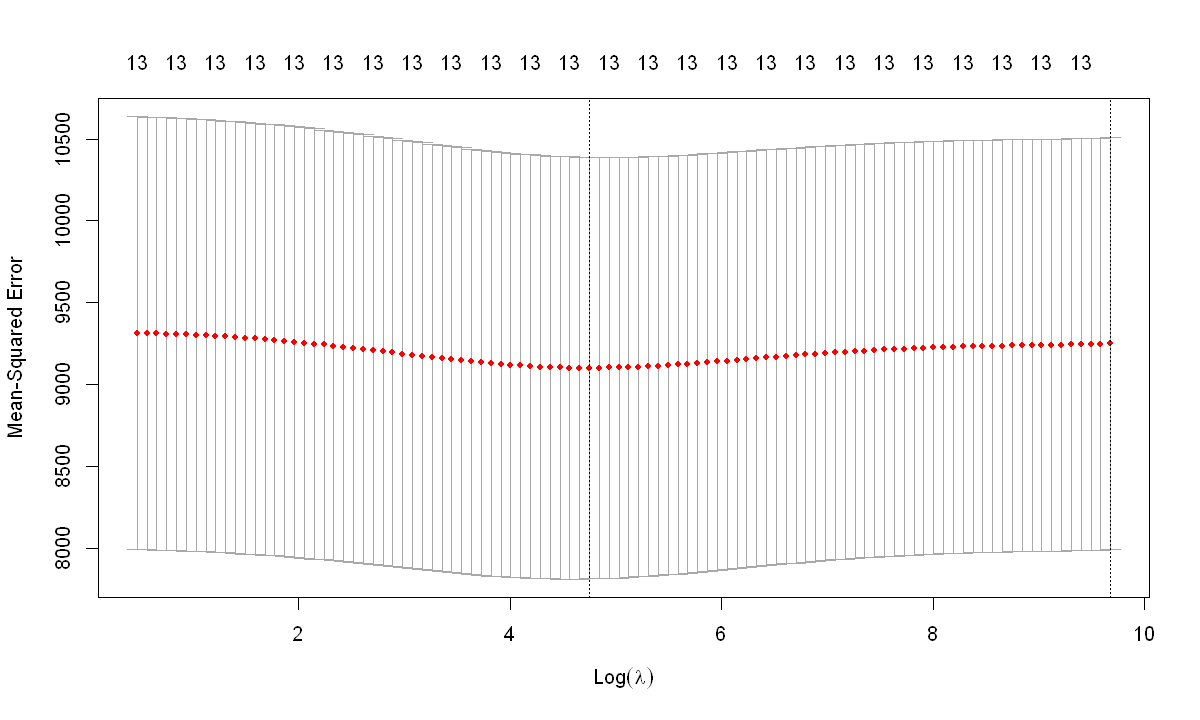

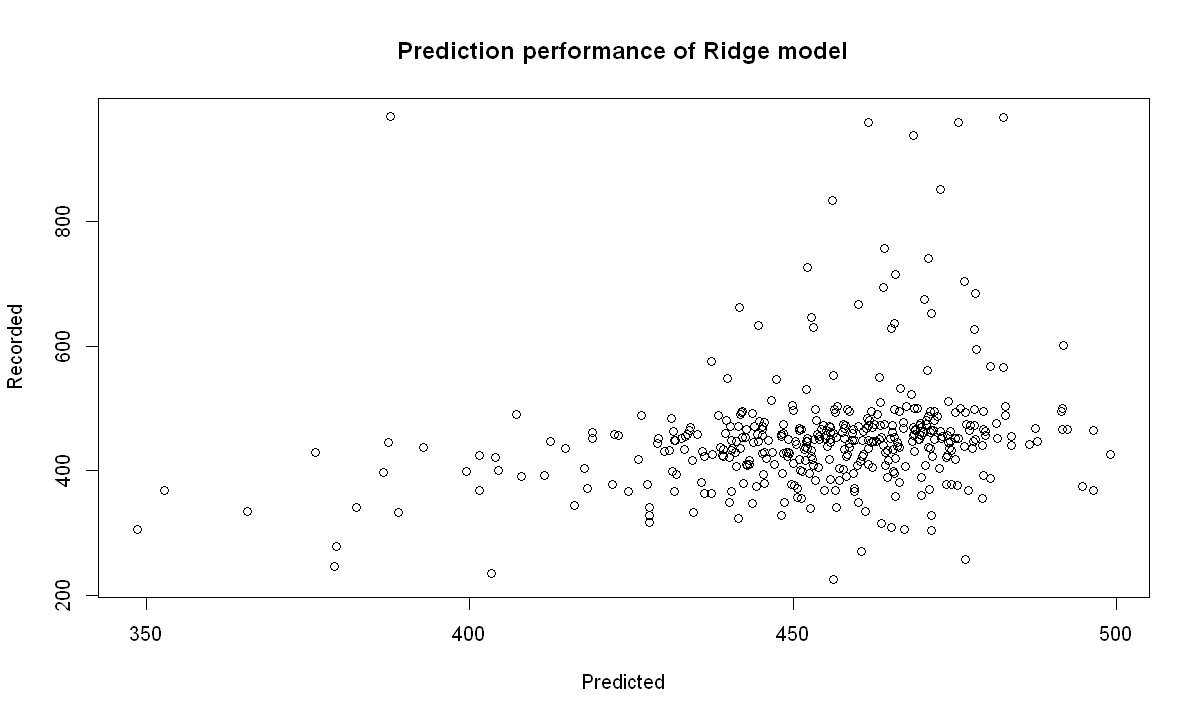

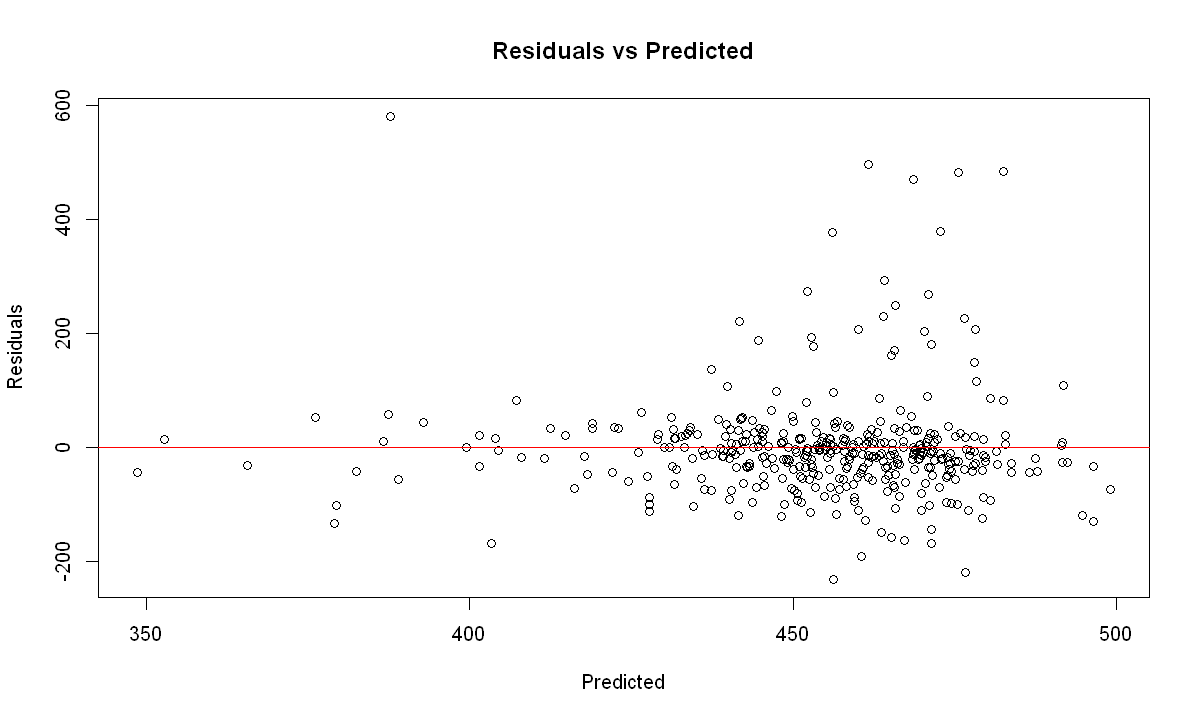

In [96]:
cv_alpha <- function(x, y, nfolds = 5) {
  alphas <- seq(0, 1, by = 0.1)
  cv_errors <- numeric(length(alphas))
  
  for (i in seq_along(alphas)) {
    fit <- cv.glmnet(x, y, alpha = alphas[i], nfolds = nfolds)
    cv_errors[i] <- min(fit$cvm)
  }
  
  best_alpha <- alphas[which.min(cv_errors)]
  return(best_alpha)}

x <- model.matrix(cleaned_data$X95th.Percentile ~ IRSAD.Decile +
            Median.Income + Gini.Coefficient + Area..Km.2. +
            closest_capital_distance + Population + Population.Density +
            Population.Change.. + Indigenous.Population.. +
            Swing +
            # Seat.Change +
            is.Safe + is.Marginal +
            Remained.Marginal, data = cleaned_data)

y <- cleaned_data$X95th.Percentile

# Fit Lasso regression model (alpha = 1 for Lasso)
cv_model_best <- cv.glmnet(x, y, alpha = 0)

# Plot the cross-validation curve
par(bg= "white")
plot(cv_model_best)

# Get the best lambda
best_lambda <- cv_model_best$lambda.min
print(best_lambda)

# Fit the final model with the best alpha and lambda
final_model_best <- glmnet(x, y, alpha = 0, lambda = best_lambda)
selected_vars <- rownames(coef(final_model_best))[-1][coef(final_model_best)[-1, 1] != 0]

# Create a formula for the selected variables
formula <- as.formula(paste("X95th.Percentile ~", paste(selected_vars, collapse = " + ")))
ridge_model <- glm(formula, data = cleaned_data)
summary(ridge_model)
options(repr.plot.width = 10, repr.plot.height = 6)
plot(predict(ridge_model, cleaned_data), cleaned_data$X95th.Percentile, 
            main="Prediction performance of Ridge model", 
            ylab= "Recorded", xlab="Predicted")
plot(ridge_model$fitted.values, resid(ridge_model), 
     main = "Residuals vs Predicted", 
     xlab = "Predicted", 
     ylab = "Residuals")
abline(h = 0, col = "red")

## Lasso Regression

[1] 9.16126



Call:
glm(formula = formula, data = cleaned_data)

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)             463.3355     5.4804  84.544  < 2e-16 ***
Indigenous.Population..  -1.1165     0.3301  -3.382  0.00079 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for gaussian family taken to be 8985.183)

    Null deviance: 3687867  on 400  degrees of freedom
Residual deviance: 3585088  on 399  degrees of freedom
AIC: 4792.4

Number of Fisher Scoring iterations: 2


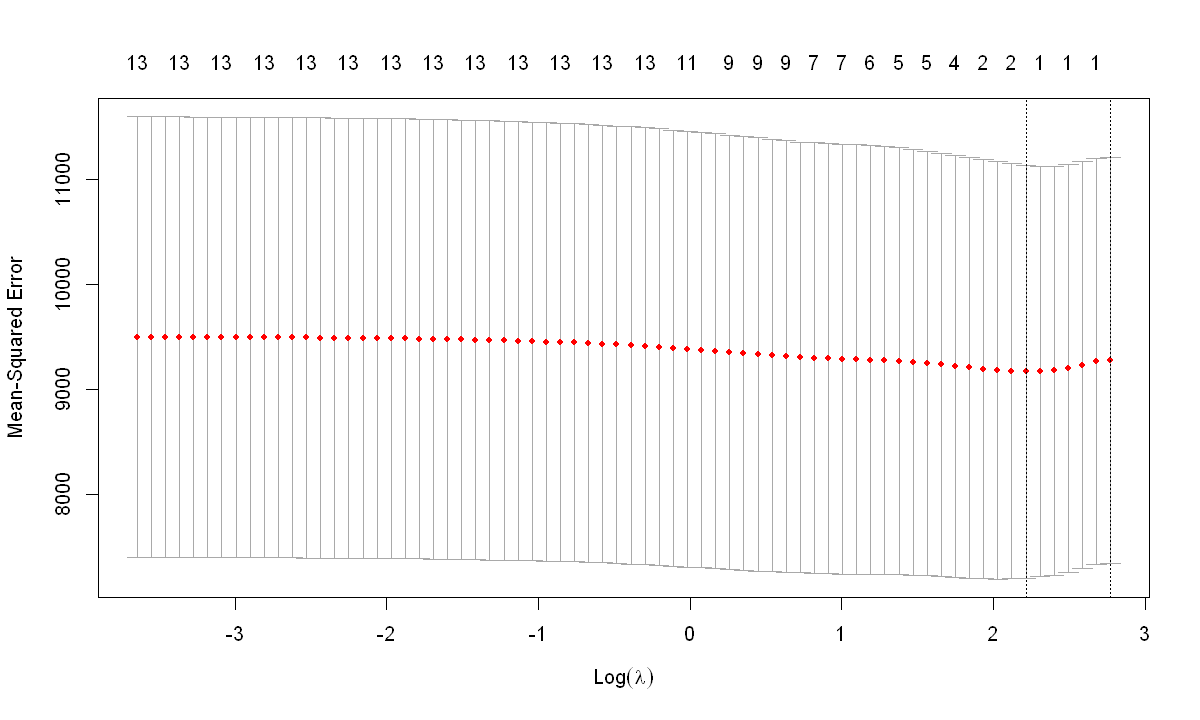

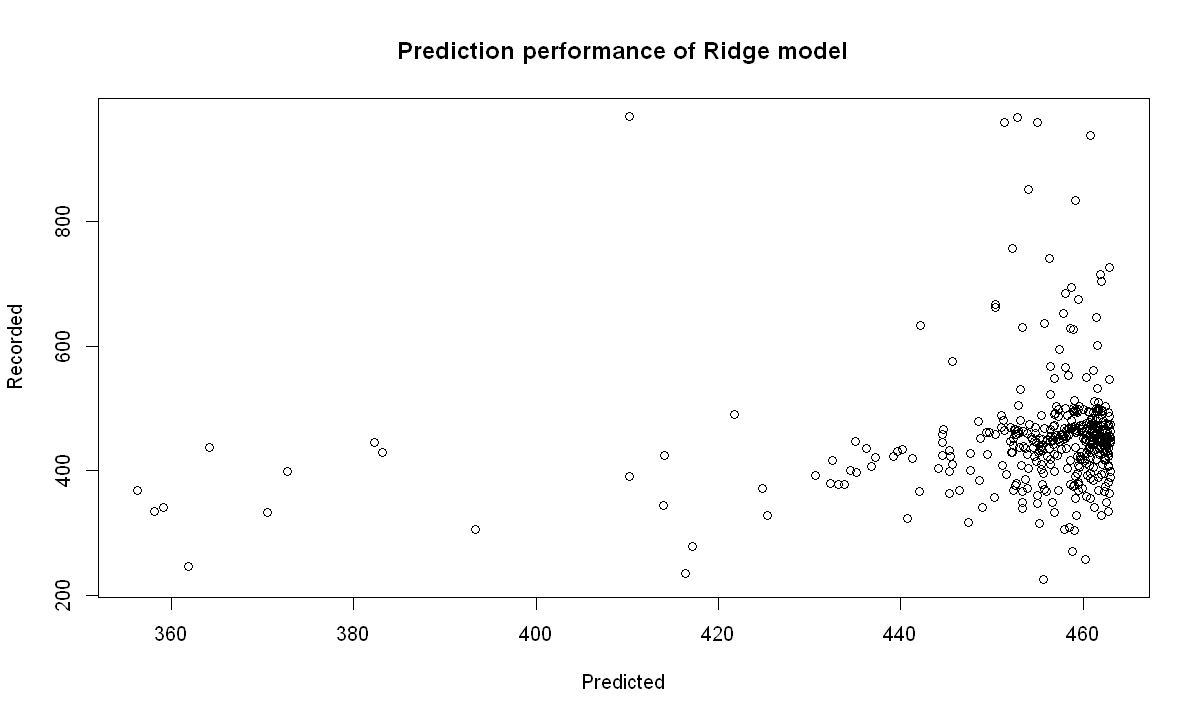

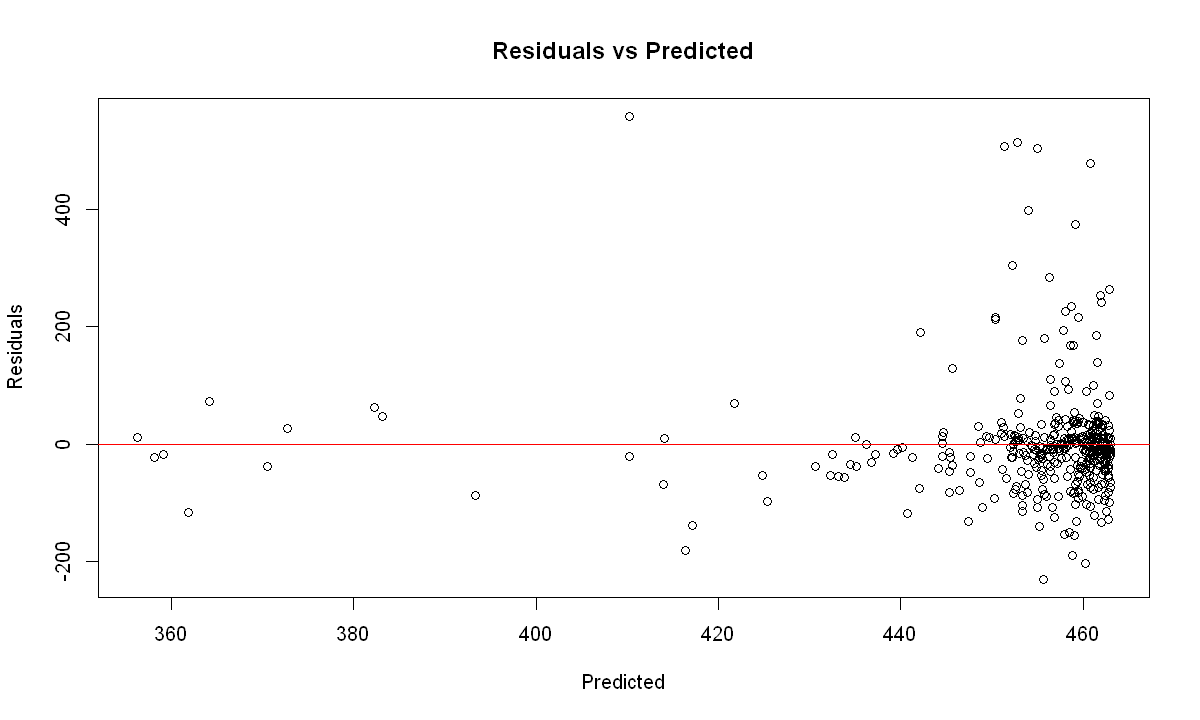

In [97]:
cv_alpha <- function(x, y, nfolds = 5) {
  alphas <- seq(0, 1, by = 0.1)
  cv_errors <- numeric(length(alphas))
  
  for (i in seq_along(alphas)) {
    fit <- cv.glmnet(x, y, alpha = alphas[i], nfolds = nfolds)
    cv_errors[i] <- min(fit$cvm)
  }
  
  best_alpha <- alphas[which.min(cv_errors)]
  return(best_alpha)}

x <- model.matrix(cleaned_data$X95th.Percentile ~ IRSAD.Decile +
            Median.Income + Gini.Coefficient + Area..Km.2. +
            closest_capital_distance + Population + Population.Density +
            Population.Change.. + Indigenous.Population.. +
            Swing +
            # Seat.Change +
            is.Safe + is.Marginal +
            Remained.Marginal, data = cleaned_data)

y <- cleaned_data$X95th.Percentile

# Fit Lasso regression model (alpha = 1 for Lasso)
cv_model_best <- cv.glmnet(x, y, alpha = 1)

# Plot the cross-validation curve
par(bg= "white")
plot(cv_model_best)

# Get the best lambda
best_lambda <- cv_model_best$lambda.min
print(best_lambda)

# Fit the final model with the best alpha and lambda
final_model_best <- glmnet(x, y, alpha = 1, lambda = best_lambda)
selected_vars <- rownames(coef(final_model_best))[-1][coef(final_model_best)[-1, 1] != 0]
if (length(selected_vars) == 0) {print('No variables selected')}

# Create a formula for the selected variables
formula <- as.formula(paste("X95th.Percentile ~", paste(selected_vars, collapse = " + ")))
lasso_model <- glm(formula, data = cleaned_data)
summary(lasso_model)
options(repr.plot.width = 10, repr.plot.height = 6)
plot(predict(lasso_model, cleaned_data), cleaned_data$X95th.Percentile, 
            main="Prediction performance of Ridge model", 
            ylab= "Recorded", xlab="Predicted")
plot(lasso_model$fitted.values, resid(lasso_model), 
     main = "Residuals vs Predicted", 
     xlab = "Predicted", 
     ylab = "Residuals")
abline(h = 0, col = "red")

## Elastic Net Regression

Best alpha: 0.5 
[1] 15.21168



Call:
glm(formula = formula, data = cleaned_data)

Coefficients:
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)               4.444e+02  5.741e+01   7.741  8.7e-14 ***
IRSAD.Decile              8.159e-01  2.622e+00   0.311   0.7559    
Median.Income            -6.840e-04  6.991e-04  -0.978   0.3285    
Gini.Coefficient          1.150e+02  8.280e+01   1.389   0.1658    
Area..Km.2.               4.977e-05  1.185e-04   0.420   0.6746    
closest_capital_distance -8.547e-03  2.017e-02  -0.424   0.6720    
Population               -2.719e-05  5.357e-05  -0.508   0.6120    
Population.Density       -4.716e-03  5.196e-03  -0.908   0.3646    
Population.Change..       7.286e+00  4.501e+00   1.619   0.1063    
Indigenous.Population..  -1.083e+00  4.717e-01  -2.296   0.0222 *  
Swing                    -4.772e-01  1.384e+00  -0.345   0.7304    
is.Safe                  -1.461e+01  1.305e+01  -1.120   0.2636    
is.Marginal              -8.006e+00  1.537e+01  -0

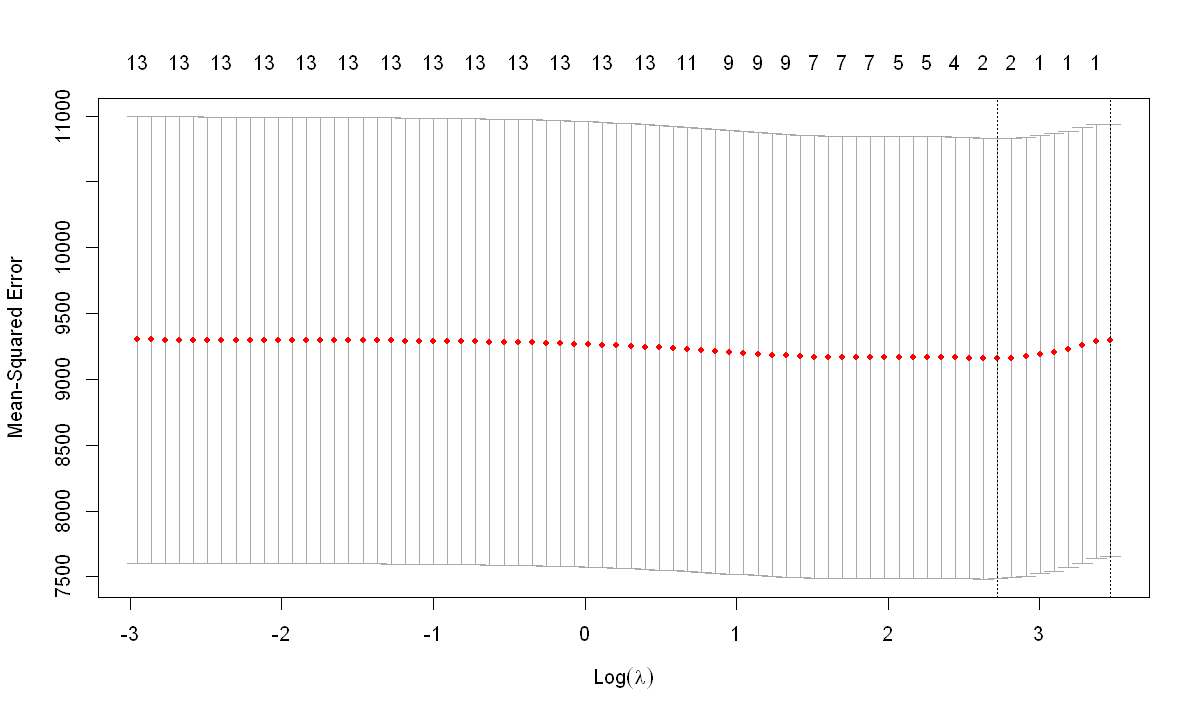

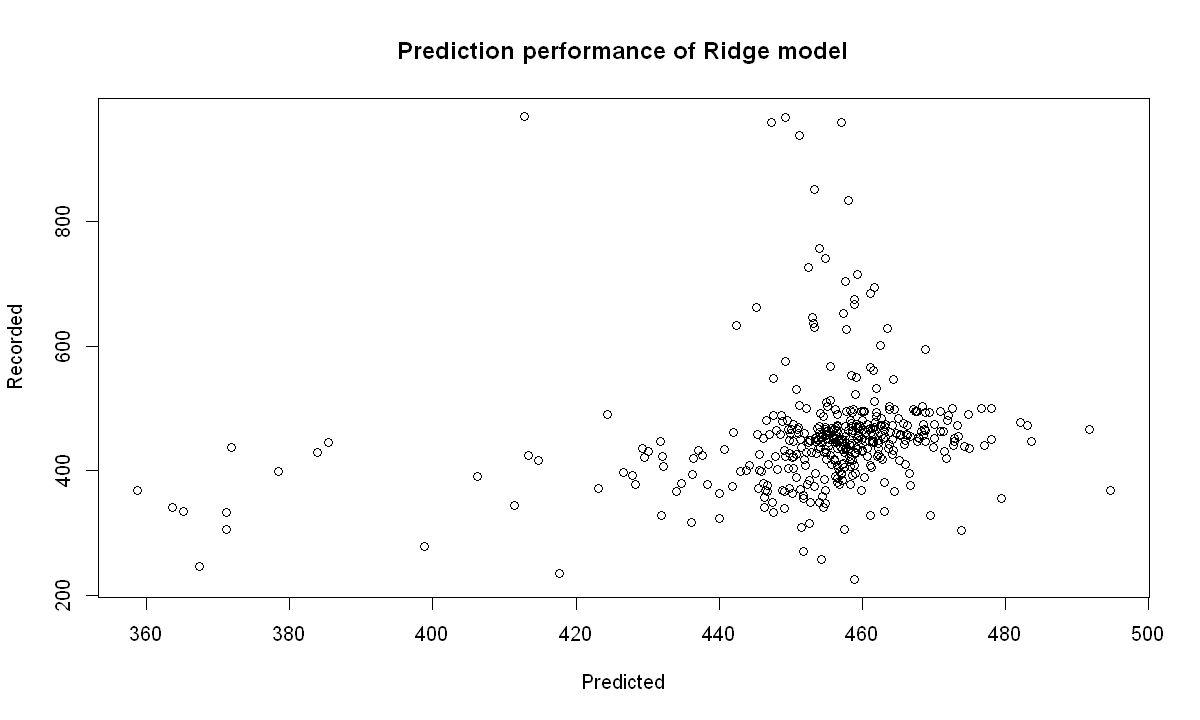

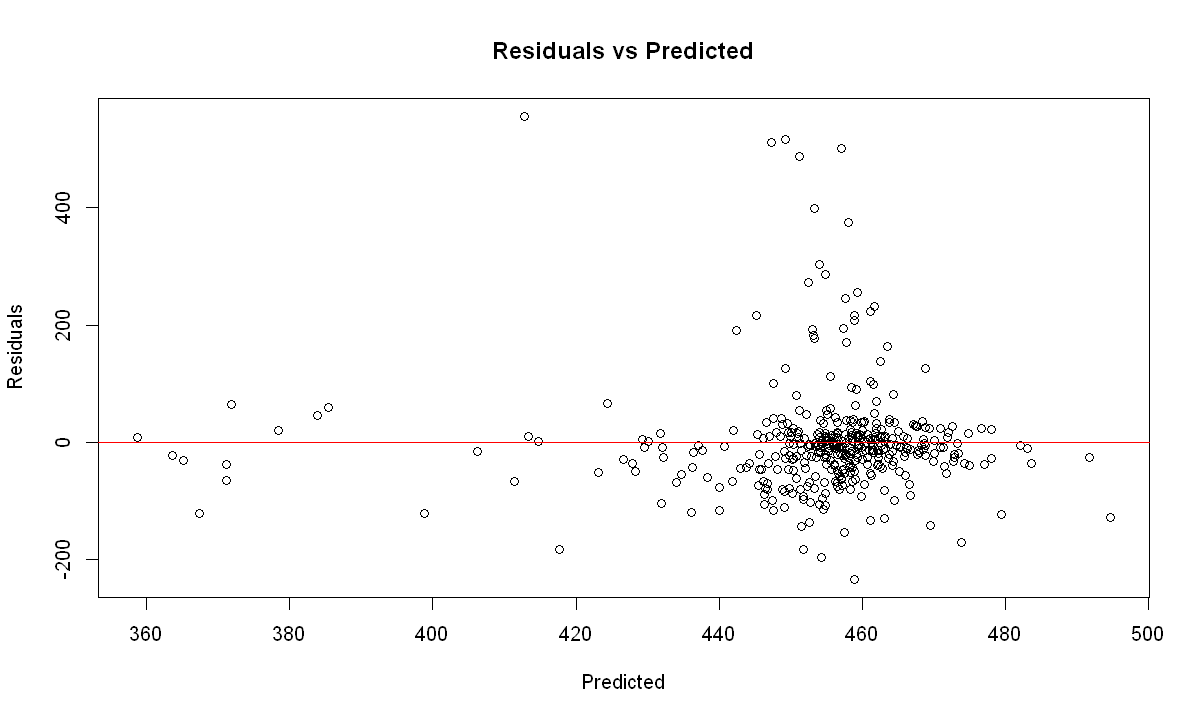

In [98]:
cv_alpha <- function(x, y, nfolds = 5) {
  alphas <- seq(0, 1, by = 0.1)
  cv_errors <- numeric(length(alphas))
  
  for (i in seq_along(alphas)) {
    fit <- cv.glmnet(x, y, alpha = alphas[i], nfolds = nfolds)
    cv_errors[i] <- min(fit$cvm)
  }
  
  best_alpha <- alphas[which.min(cv_errors)]
  return(best_alpha)}

x <- model.matrix(cleaned_data$X95th.Percentile ~ IRSAD.Decile +
            Median.Income + Gini.Coefficient + Area..Km.2. +
            closest_capital_distance + Population + Population.Density +
            Population.Change.. + Indigenous.Population.. +
            Swing +
            # Seat.Change +
            is.Safe + is.Marginal +
            Remained.Marginal, data = cleaned_data)

y <- cleaned_data$X95th.Percentile

# Find the best alpha
best_alpha <- cv_alpha(x, y)
cat("Best alpha:", best_alpha, "\n")

# Fit Lasso regression model (alpha = 1 for Lasso)
cv_model_best <- cv.glmnet(x, y, alpha = best_alpha)

# Plot the cross-validation curve
par(bg= "white")
plot(cv_model_best)

# Get the best lambda
best_lambda <- cv_model_best$lambda.min
print(best_lambda)

# Fit the final model with the best alpha and lambda
final_model_best <- glmnet(x, y, alpha = best_alpha, lambda = best_lambda)
selected_vars <- rownames(coef(final_model_best))[-1][coef(final_model_best)[-1, 1] != 0]
if (length(selected_vars) == 0) {print('No variables selected')}

# Create a formula for the selected variables
formula <- as.formula(paste("X95th.Percentile ~", paste(selected_vars, collapse = " + ")))
elastic_model <- glm(formula, data = cleaned_data)
summary(ridge_model)
options(repr.plot.width = 10, repr.plot.height = 6)
plot(predict(elastic_model, cleaned_data), cleaned_data$X95th.Percentile, 
            main="Prediction performance of Ridge model", 
            ylab= "Recorded", xlab="Predicted")
plot(elastic_model$fitted.values, resid(elastic_model), 
     main = "Residuals vs Predicted", 
     xlab = "Predicted", 
     ylab = "Residuals")
abline(h = 0, col = "red")

## idk, something else now

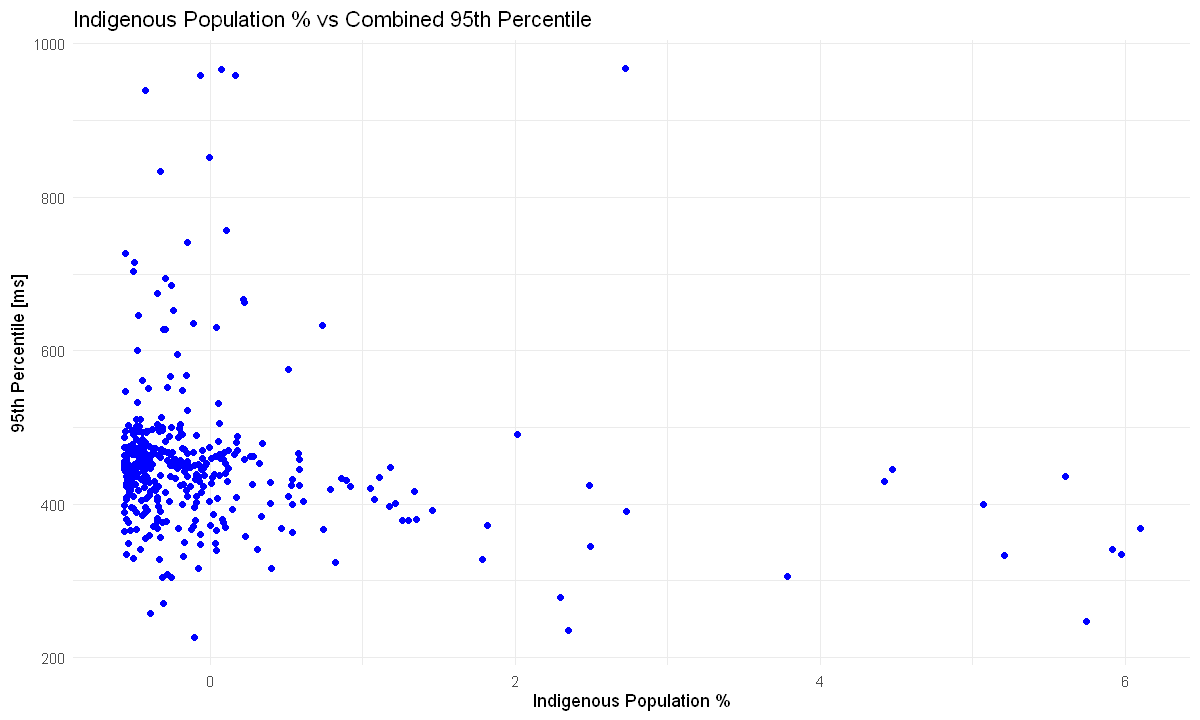

In [85]:
ggplot(cleaned_scaled, aes(x = Indigenous.Population.., y = X95th.Percentile)) +
  geom_point(color = "blue") +
  labs(title = "Indigenous Population % vs Combined 95th Percentile", x = "Indigenous Population %", y = "95th Percentile [ms]") +
  theme_minimal()

In [ ]:
apply(cleaned_data, 2, var)
nzv <- nearZeroVar(data, saveMetrics = TRUE)
nzv[nzv$zeroVar == TRUE, ]

In [ ]:
pca_result <- prcomp(cleaned_data[, c("IRSD.Decile", "IRSAD.Decile", "IER.Decile",
                            "IEO.Decile", "Population", "Gini.Coefficient",
                            "Population.Change", "X..Population.Change", 
                            "Area..Km.2.", "Population.Density", 
                            "Indigenous.Population", 
                            "X..Indigenous.Population")], 
                            scale. = TRUE)  # Standardize data before PCA

# View the PCA summary to see the proportion of variance
summary(pca_result)

# Use the first few principal components that explain the most variance
pca_components <- pca_result$x[, 1:10]  # Replace 1:5 with desired slice

# Fit a new model using the principal components
pca_model <- lm(X95th.5th.Ratio ~ pca_components, data = cleaned_data)

# View the summary of the new model
summary(pca_model)

### visualise against certain significant variables

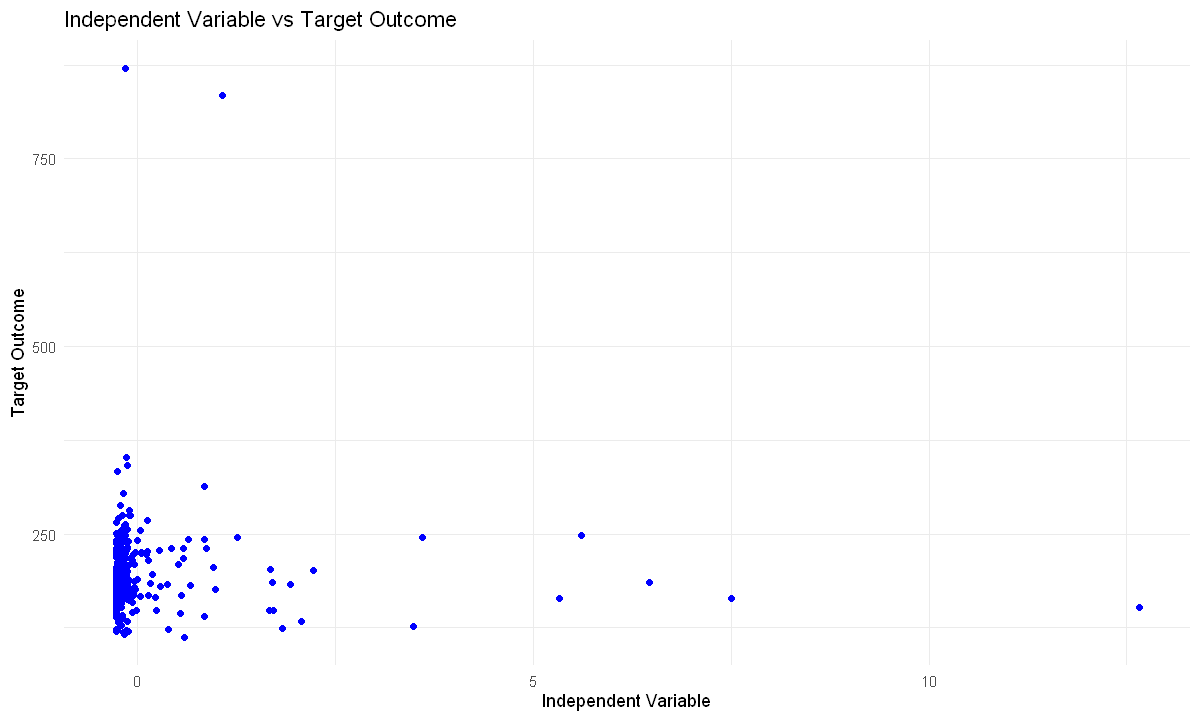

In [32]:
ggplot(cleaned_scaled, aes(x = Area..Km.2., y = X5th.Percentile)) +
  geom_point(color = "blue") +
  labs(title = "Independent Variable vs Target Outcome", x = "Independent Variable", y = "Target Outcome") +
  theme_minimal()

### perform and plot the predictions

In [ ]:
par(bg = "white")
predictions <- predict(fit, cleaned_data)
plot(predict(fit, cleaned_data), cleaned_data$X95th.Percentile)
#calculate mean squared error
mean((predictions - target_variable)^2)